In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

In [14]:
rng = np.random.RandomState(20170720)
data = pd.read_csv('data.csv')

n_bootstrap = 10000
repetitions = 1000

In [15]:
state_black = data['Fraction Black'].values
state_woman = data['Fraction Female'].values

In [16]:
for ii in range(repetitions):
    senate_woman = rng.rand(n_bootstrap, 50, 2) < state_woman[np.newaxis, :, np.newaxis]
    senate_black = rng.rand(n_bootstrap, 50, 2) < state_black[np.newaxis, :, np.newaxis]
    both_women_per_state = senate_woman[..., 0] * senate_woman[..., 1]
    if ii == 0:
        n_states_2_women = both_women_per_state.sum(axis=1)
        n_black_women = np.sum(senate_woman * senate_black, axis=(1, 2))
        n_black = senate_black.sum(axis=(1, 2))
        n_women = senate_woman.sum(axis=(1, 2))
    else:
        n_states_2_women = np.concatenate([n_states_2_women, both_women_per_state.sum(axis=1)])
        n_black_women = np.concatenate([n_black_women, np.sum(senate_woman * senate_black, axis=(1, 2))])
        n_black = np.concatenate([n_black, senate_black.sum(axis=(1, 2))])
        n_women = np.concatenate([n_women, senate_woman.sum(axis=(1, 2))])

In [22]:
def make_plot(data, reality, description):
    f, ax = plt.subplots(1, figsize=(5, 5))
    h, b, p = ax.hist(data, bins=np.arange(0, 101), normed=True)
    plt.plot([reality + .5, reality + .5], [0, 1], c='black')
    ax.set_yscale('log')
    ax.set_ylim(None, 1)
    ax.set_xlim(-1, data.max() + 2)
    ax.set_xlabel('Number')
    ax.set_ylabel('Probability')
    plt.show()
    print('p for {} or fewer {}: {}'.format(reality, description, np.mean(data <= reality)))
    print('mean for {}: {}'.format(description, data.mean()))
    print('mode for {}: {}'.format(description, h.argmax()))

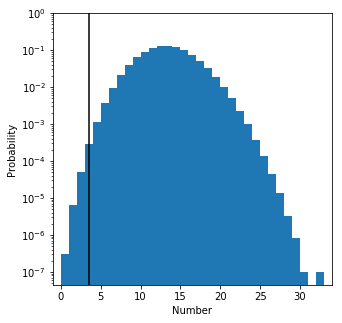

p for 3 or fewer states with 2 women senators: 0.000338
mean for states with 2 women senators: 12.8575782
mode for states with 2 women senators: 13


In [23]:
make_plot(n_states_2_women, 3, 'states with 2 women senators')

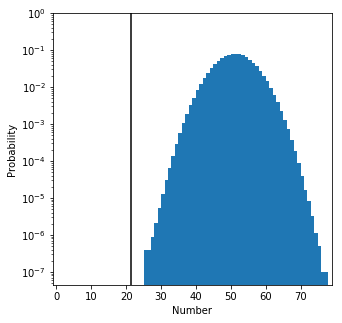

p for 21 or fewer women senators: 0.0
mean for women senators: 50.7032995
mode for women senators: 51


In [24]:
make_plot(n_women, 21, 'women senators')

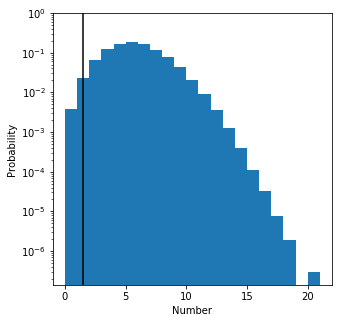

p for 1 or fewer Black women senators: 0.0262999
mean for Black women senators: 5.2797153
mode for Black women senators: 5


In [25]:
make_plot(n_black_women, 1, 'Black women senators')

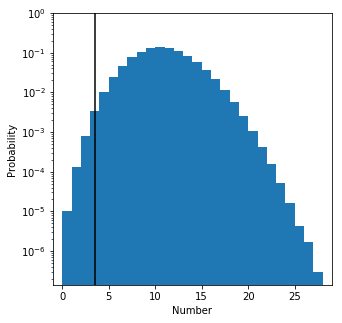

p for 3 or fewer Black senators: 0.004333
mean for Black senators: 10.3399782
mode for Black senators: 10


In [26]:
make_plot(n_black, 3, 'Black senators')